<a href="https://colab.research.google.com/github/MatthewSebastian15/datacomp/blob/main/DataComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [2]:
url = "https://raw.githubusercontent.com/MatthewSebastian15/datacomp/main/public-transport.csv"
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [4]:
df.describe()

payCardID  payCardBirthDate     direction  tapInStopsLat  \
count  3.790000e+04      37900.000000  37900.000000   37900.000000   
mean   4.250060e+17       1990.089314      0.500633      -6.214838   
std    1.321699e+18         13.051482      0.500006       0.057911   
min    6.040368e+10       1946.000000      0.000000      -6.394973   
25%    1.800442e+14       1982.000000      0.000000      -6.245863   
50%    3.507947e+15       1990.000000      1.000000      -6.214587   
75%    4.699023e+15       2001.000000      1.000000      -6.175528   
max    4.997694e+18       2012.000000      1.000000      -6.089429   

       tapInStopsLon  stopStartSeq  tapOutStopsLat  tapOutStopsLon  \
count   37900.000000  37900.000000    36556.000000    36556.000000   
mean      106.841554     13.572480       -6.214651      106.841233   
std         0.060369     12.237623        0.059022        0.060999   
min       106.614730      0.000000       -6.394973      106.614730   
25%       106.803470      4.000000       -6.247225      106.801750   
50%       106.834830     10.000000       -6.214718      106.834580   
75%       106.882270     19.000000       -6.174736      106.883030   
max       107.023950     68.000000       -6.091746      107.023660   

         stopEndSeq     payAmount  
count  36556.000000  36893.000000  
mean      21.219909   2699.712683  
std       13.800689   4212.225592  
min        1.000000      0.000000  
25%       11.000000      0.000000  
50%       18.000000   3500.000000  
75%       29.000000   3500.000000  
max       77.000000  20000.000000

In [5]:
df.isnull().sum()

transID                0
payCardID              0
payCardBank            0
payCardName            0
payCardSex             0
payCardBirthDate       0
corridorID          1257
corridorName        1930
direction              0
tapInStops          1213
tapInStopsName         0
tapInStopsLat          0
tapInStopsLon          0
stopStartSeq           0
tapInTime              0
tapOutStops         2289
tapOutStopsName     1344
tapOutStopsLat      1344
tapOutStopsLon      1344
stopEndSeq          1344
tapOutTime          1344
payAmount           1007
dtype: int64

# Data Cleaning & Preprocessing

## CorridorID & CorridorName

In [6]:
corridor_map_id_to_name = df[['corridorID','corridorName']].dropna().drop_duplicates().set_index('corridorID')['corridorName'].to_dict()
corridor_map_name_to_id = {v:k for k,v in corridor_map_id_to_name.items()}
df['corridorName'] = df['corridorName'].fillna(df['corridorID'].map(corridor_map_id_to_name))
df['corridorID'] = df['corridorID'].fillna(df['corridorName'].map(corridor_map_name_to_id))
df = df.dropna(subset=['corridorID','corridorName'])

## Mapping Stops

In [7]:
stop_map_in = df[['tapInStops','tapInStopsName']].dropna().drop_duplicates().set_index('tapInStopsName')['tapInStops'].to_dict()
df['tapInStops'] = df['tapInStops'].fillna(df['tapInStopsName'].map(stop_map_in))
df = df.dropna(subset=['tapInStops'])

In [8]:
stop_map_out = df[['tapOutStops','tapOutStopsName']].dropna().drop_duplicates().set_index('tapOutStopsName')['tapOutStops'].to_dict()
df['tapOutStops'] = df['tapOutStops'].fillna(df['tapOutStopsName'].map(stop_map_out))
df['tapOutStops'] = df['tapOutStops'].fillna('Unknown')

## payAmount & fare_category

In [9]:
corridor_fare_map = df.groupby('corridorID')['payAmount'].median()
df['payAmount'] = df['payAmount'].fillna(df['corridorID'].map(corridor_fare_map))
df['payAmount'] = df['payAmount'].fillna(df['payAmount'].median())
df['payAmount'] = df['payAmount'].clip(lower=0)

df['fare_category'] = pd.cut(df['payAmount'], bins=[-1, 0, 3500, float('inf')],labels=['Free', 'Normal', 'Premium'])

## Convert Datetime

In [10]:
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')

df['duration_minutes'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60
df = df[(df['duration_minutes'] > 0.5) & (df['duration_minutes'] < 240)]

In [11]:
df[['tapInTime','tapOutTime','duration_minutes']].head(15)

tapInTime          tapOutTime  duration_minutes
0  2023-04-03 05:21:44 2023-04-03 06:00:53         39.150000
1  2023-04-03 05:42:44 2023-04-03 06:40:01         57.283333
2  2023-04-03 05:59:06 2023-04-03 06:50:55         51.816667
3  2023-04-03 05:44:51 2023-04-03 06:28:16         43.416667
4  2023-04-03 06:17:35 2023-04-03 06:57:03         39.466667
5  2023-04-03 05:08:01 2023-04-03 05:52:25         44.400000
8  2023-04-03 06:01:44 2023-04-03 06:51:12         49.466667
9  2023-04-03 05:57:47 2023-04-03 06:51:12         53.416667
10 2023-04-03 06:32:28 2023-04-03 07:23:54         51.433333
11 2023-04-03 06:22:10 2023-04-03 06:50:21         28.183333
12 2023-04-03 06:15:04 2023-04-03 07:08:31         53.450000
13 2023-04-03 06:12:14 2023-04-03 07:07:35         55.350000
14 2023-04-03 05:38:44 2023-04-03 06:09:17         30.550000
15 2023-04-03 06:43:20 2023-04-03 07:07:17         23.950000
16 2023-04-03 06:49:48 2023-04-03 07:47:42         57.900000

## Time Features

In [12]:
df['tapInTime'] = pd.to_datetime(df['tapInTime'], errors='coerce')
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'], errors='coerce')

df['is_complete_trip'] = ~df['tapOutTime'].isnull()

df['day_of_week'] = df['tapInTime'].dt.dayofweek
df['tapInHour'] = df['tapInTime'].dt.hour

In [13]:
df_Time = df[['tapInTime', 'day_of_week', 'tapInHour']]
df_Time

tapInTime  day_of_week  tapInHour
0     2023-04-03 05:21:44            0          5
1     2023-04-03 05:42:44            0          5
2     2023-04-03 05:59:06            0          5
3     2023-04-03 05:44:51            0          5
4     2023-04-03 06:17:35            0          6
...                   ...          ...        ...
37895 2023-04-21 18:18:37            4         18
37896 2023-04-18 21:52:31            1         21
37897 2023-04-04 10:29:47            1         10
37898 2023-04-15 19:59:26            5         19
37899 2023-04-12 21:08:12            2         21

[35445 rows x 3 columns]

day_of_week

0: Senin

1: Selasa

2: Rabu

3: Kamis

4: Jumat

5: Sabtu

6: Minggu

tapInHour

tapInTime : menggunakan format waktu 0 - 23

0 = jam 00.00–00.59 (tengah malam)

6 = jam 06.00–06.59 (pagi)

17 = jam 17.00–17.59 (sore / jam sibuk)

## Distance Feature

distance_km : Jarak antara halte yang sudah di tempuh

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['tapInStopsLat'], df['tapInStopsLon'],
                              df['tapOutStopsLat'], df['tapOutStopsLon'])

In [15]:
df_distance = df[['tapInStopsLat','tapInStopsLon','tapOutStopsLat','tapOutStopsLon','distance_km']]
df_distance

tapInStopsLat  tapInStopsLon  tapOutStopsLat  tapOutStopsLon  \
0          -6.184631      106.84402       -6.203101       106.85715   
1          -6.228700      106.83302       -6.217152       106.81892   
2          -6.133132      106.81435       -6.133731       106.81475   
3          -6.195743      106.93526       -6.183068       106.93194   
4          -6.149650      106.88900       -6.135355       106.81143   
...              ...            ...             ...             ...   
37895      -6.196892      106.82309       -6.290967       106.82365   
37896      -6.290154      106.88116       -6.291075       106.88634   
37897      -6.216247      106.81676       -6.370321       106.89628   
37898      -6.188656      106.80954       -6.188861       106.81135   
37899      -6.236466      106.74786       -6.238340       106.77752   

       distance_km  
0         2.514901  
1         2.019437  
2         0.079950  
3         1.456398  
4         8.721936  
...            ...  
37895    10.460846  
37896     0.581609  
37897    19.255109  
37898     0.201384  
37899     3.285133  

[35445 rows x 5 columns]

# Feature Engineering

## Duration

In [16]:
df['duration_minutes'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60

In [17]:
df[['tapInTime','tapOutTime','duration_minutes']].head(15)

tapInTime          tapOutTime  duration_minutes
0  2023-04-03 05:21:44 2023-04-03 06:00:53         39.150000
1  2023-04-03 05:42:44 2023-04-03 06:40:01         57.283333
2  2023-04-03 05:59:06 2023-04-03 06:50:55         51.816667
3  2023-04-03 05:44:51 2023-04-03 06:28:16         43.416667
4  2023-04-03 06:17:35 2023-04-03 06:57:03         39.466667
5  2023-04-03 05:08:01 2023-04-03 05:52:25         44.400000
8  2023-04-03 06:01:44 2023-04-03 06:51:12         49.466667
9  2023-04-03 05:57:47 2023-04-03 06:51:12         53.416667
10 2023-04-03 06:32:28 2023-04-03 07:23:54         51.433333
11 2023-04-03 06:22:10 2023-04-03 06:50:21         28.183333
12 2023-04-03 06:15:04 2023-04-03 07:08:31         53.450000
13 2023-04-03 06:12:14 2023-04-03 07:07:35         55.350000
14 2023-04-03 05:38:44 2023-04-03 06:09:17         30.550000
15 2023-04-03 06:43:20 2023-04-03 07:07:17         23.950000
16 2023-04-03 06:49:48 2023-04-03 07:47:42         57.900000

## Age

In [18]:
df = df[(df['payCardBirthDate'] >= 1900) & (df['payCardBirthDate'] <= 2025)]
df['age'] = 2025 - df['payCardBirthDate']

In [19]:
df[['payCardBirthDate', 'age']].head(15)

payCardBirthDate  age
0               2008   17
1               1997   28
2               1992   33
3               1978   47
4               1982   43
5               1993   32
8               1992   33
9               2004   21
10              1997   28
11              1984   41
12              1988   37
13              2002   23
14              1975   50
15              2011   14
16              2004   21

## Day & Hour

In [20]:
df['day_of_week'] = df['tapInTime'].dt.dayofweek
df['tapInHour'] = df['tapInTime'].dt.hour

def time_category(hour):
    if 0 <= hour <= 5:        # 00:00 - 05:59
        return "Early Morning"
    elif 6 <= hour <= 8:      # 06:00 - 08:59
        return "Morning Rush"
    elif 9 <= hour <= 15:     # 09:00 - 15:59
        return "Midday"
    elif 16 <= hour <= 18:    # 16:00 - 18:59
        return "Evening Rush"
    elif 19 <= hour <= 23:    # 19:00 - 23:59
        return "Night"
    else:
        return "Unknown"

df['time_category'] = df['tapInHour'].apply(time_category)

In [21]:
df[['day_of_week','tapInHour','time_category']]

day_of_week  tapInHour  time_category
0                0          5  Early Morning
1                0          5  Early Morning
2                0          5  Early Morning
3                0          5  Early Morning
4                0          6   Morning Rush
...            ...        ...            ...
37895            4         18   Evening Rush
37896            1         21          Night
37897            1         10         Midday
37898            5         19          Night
37899            2         21          Night

[35445 rows x 3 columns]

## Distance

In [22]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['tapInStopsLat'], df['tapInStopsLon'],
                              df['tapOutStopsLat'], df['tapOutStopsLon'])

In [23]:
df[['distance_km']]

distance_km
0         2.514901
1         2.019437
2         0.079950
3         1.456398
4         8.721936
...            ...
37895    10.460846
37896     0.581609
37897    19.255109
37898     0.201384
37899     3.285133

[35445 rows x 1 columns]

## Average Speed

In [24]:
df['avg_speed_kmph'] = df['distance_km'] / (df['duration_minutes'] / 60)

In [25]:
df[['avg_speed_kmph']]

avg_speed_kmph
0            3.854255
1            2.115209
2            0.092577
3            2.012681
4           13.259700
...               ...
37895        6.457312
37896        0.973404
37897        6.503884
37898        0.425459
37899        7.386933

[35445 rows x 1 columns]

# Outlier Handling

In [26]:
df = df[
    (df['tapInStopsLat'].between(-6.4, -6.0)) &
    (df['tapInStopsLon'].between(106.6, 107.0)) &
    (df['tapOutStopsLat'].between(-6.4, -6.0)) &
    (df['tapOutStopsLon'].between(106.6, 107.0))
]
df = df[(df['is_complete_trip']) & (df['stopEndSeq'] > df['stopStartSeq'])]
df = df[(df['duration_minutes'] >= 1) & (df['duration_minutes'] <= 180)]
df = df[df['avg_speed_kmph'] <= 80]
df = df.drop_duplicates(subset=['transID'])

print("Jumlah data setelah preprocessing:", df.shape)
print(df.isnull().sum())

Jumlah data setelah preprocessing: (35142, 31)
transID             0
payCardID           0
payCardBank         0
payCardName         0
payCardSex          0
payCardBirthDate    0
corridorID          0
corridorName        0
direction           0
tapInStops          0
tapInStopsName      0
tapInStopsLat       0
tapInStopsLon       0
stopStartSeq        0
tapInTime           0
tapOutStops         0
tapOutStopsName     0
tapOutStopsLat      0
tapOutStopsLon      0
stopEndSeq          0
tapOutTime          0
payAmount           0
fare_category       0
duration_minutes    0
is_complete_trip    0
day_of_week         0
tapInHour           0
distance_km         0
age                 0
time_category       0
avg_speed_kmph      0
dtype: int64


# Exploratory Data Analysis (EDA)

## Distribusi umur per gender

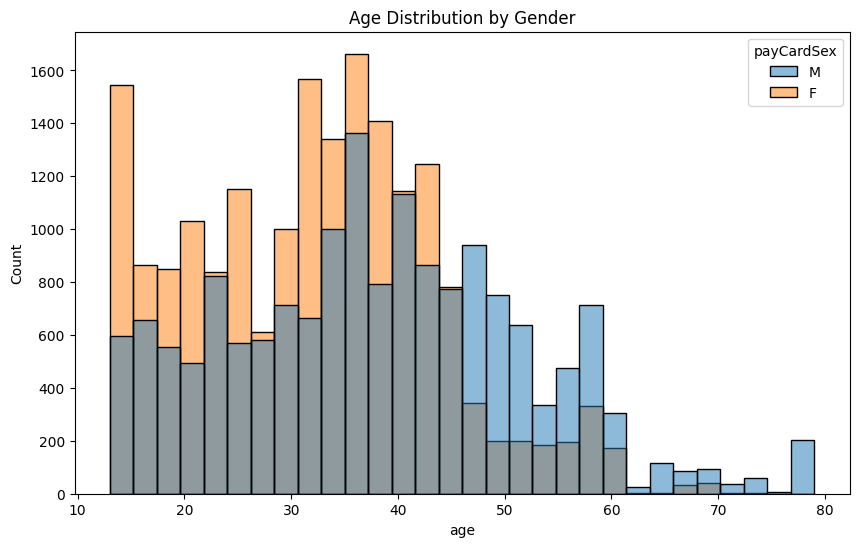

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='payCardSex', bins=30)
plt.title('Age Distribution by Gender')
plt.show()

## Distribusi tap-in per jam

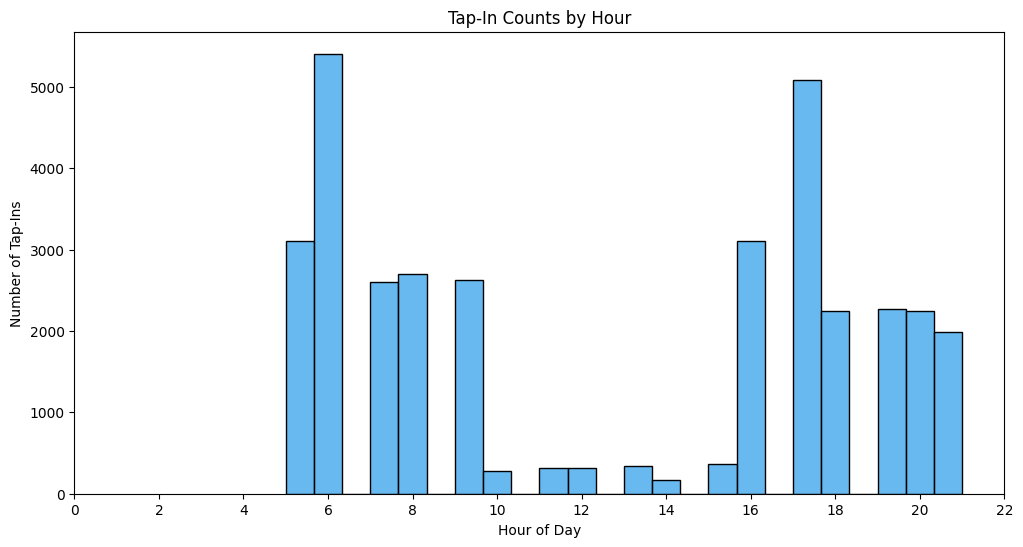

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tapInHour', bins=24, color='#36A2EB')
plt.title('Tap-In Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tap-Ins')
plt.xticks(ticks=range(0, 24, 2))
plt.show()

## Top Koridor

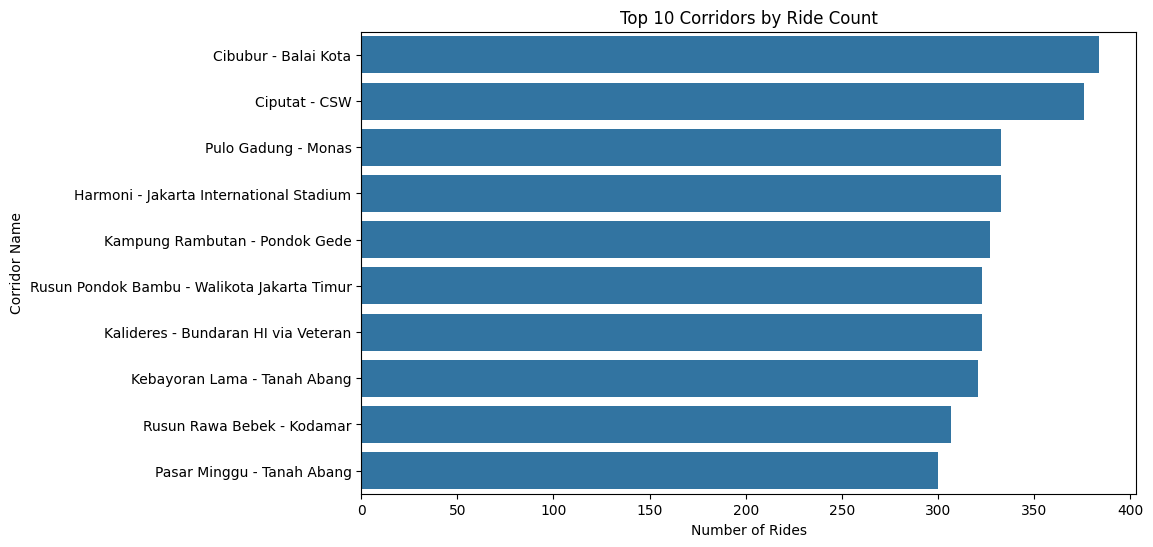

                                         transID  payAmount  duration_minutes
corridorName                                                                 
Cibubur - Balai Kota                         384    20000.0         72.214453
Ciputat - CSW                                376     3500.0         76.091090
Harmoni - Jakarta International Stadium      333     3500.0         71.931281
Pulo Gadung - Monas                          333     3500.0         71.594645
Kampung Rambutan - Pondok Gede               327        0.0         71.904434


In [29]:
top_corridors = df['corridorName'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corridors.values, y=top_corridors.index)
plt.title('Top 10 Corridors by Ride Count')
plt.xlabel('Number of Rides')
plt.ylabel('Corridor Name')
plt.show()

summary = df[df['is_complete_trip']].groupby('corridorName').agg({
    'transID': 'count',
    'payAmount': 'mean',
    'duration_minutes': 'mean'
}).sort_values('transID', ascending=False).head(5)
print(summary)

## Distribusi tarif

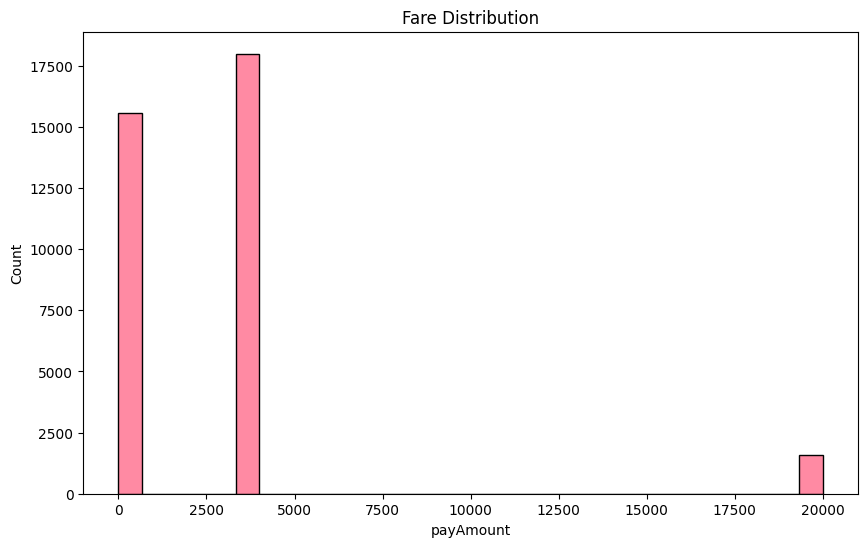

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='payAmount', bins=30, color='#FF6384')
plt.title('Fare Distribution')
plt.show()

## Heatmap korelasi

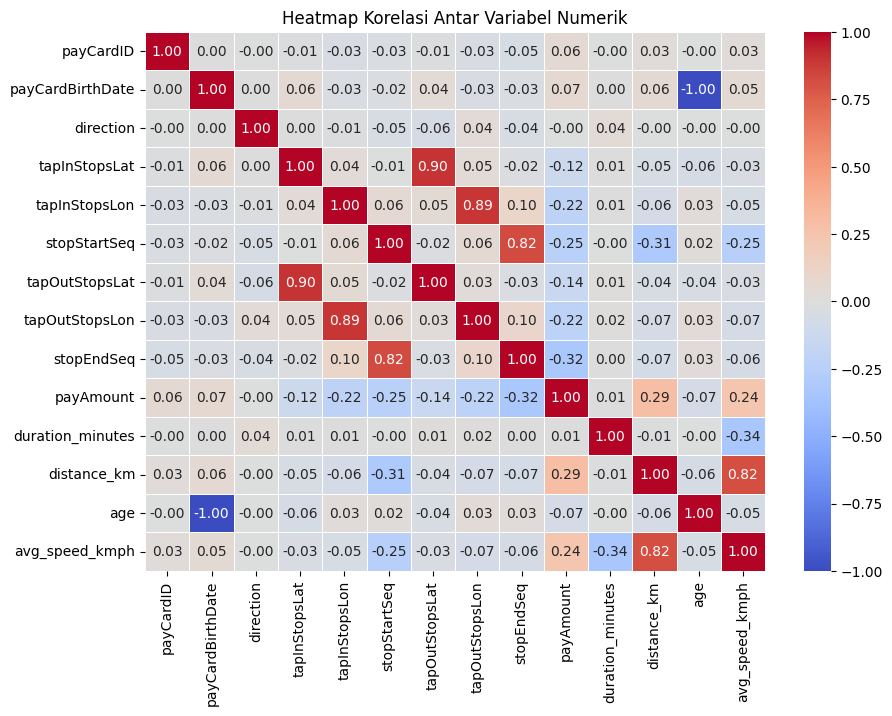

In [31]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")
plt.title("Heatmap Korelasi Antar Variabel Numerik")
plt.show()

## General Map Analysis

In [32]:
import folium
from IPython.display import display

# Aggregate tap-in counts by stop
stop_counts = df.groupby(['tapInStopsName', 'tapInStopsLat', 'tapInStopsLon']).size().reset_index(name='tap_in_count')

# Create a map centered on Jakarta
m = folium.Map(location=[-6.2, 106.8], zoom_start=12)

# Add markers for each stop, sized by tap-in count
for _, row in stop_counts.iterrows():
    folium.CircleMarker(
        location=[row['tapInStopsLat'], row['tapInStopsLon']],
        radius=min(row['tap_in_count'] / 100, 20),  # Scale radius, cap at 20
        popup=f"{row['tapInStopsName']}: {row['tap_in_count']} tap-ins",
        fill=True,
        fill_color='blue',
        color='blue',
        fill_opacity=0.6
    ).add_to(m)

# Save the map
# m.save('jakarta_tapin_map.html')

display(m)

## Boxplot kategori vs durasi

/tmp/ipython-input-1169705541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fare_category', y='duration_minutes', data=df, palette="Set2")


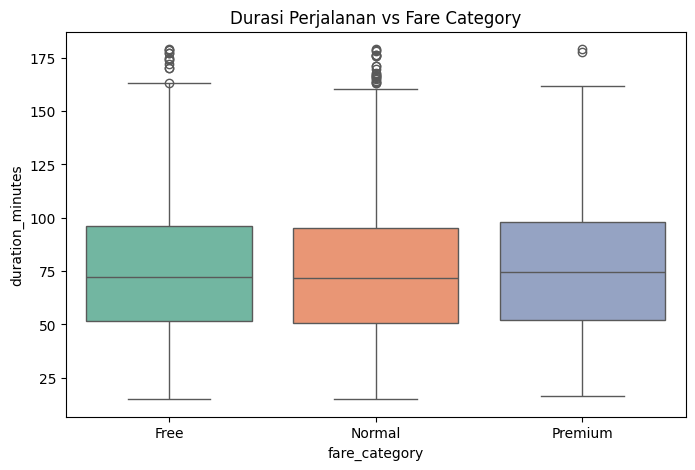

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='fare_category', y='duration_minutes', data=df, palette="Set2")
plt.title("Durasi Perjalanan vs Fare Category")
plt.show()

/tmp/ipython-input-3940255936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='duration_minutes', data=df, palette="Set3")


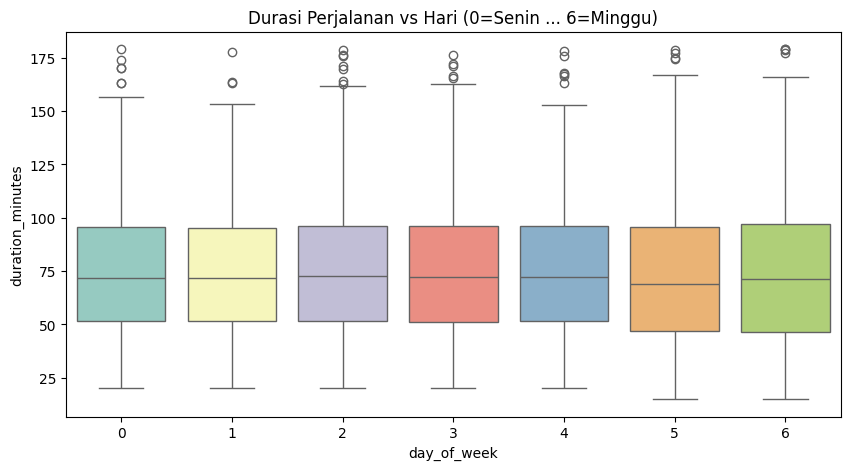

In [34]:
plt.figure(figsize=(10,5))
sns.boxplot(x='day_of_week', y='duration_minutes', data=df, palette="Set3")
plt.title("Durasi Perjalanan vs Hari (0=Senin ... 6=Minggu)")
plt.show()

## Kecepatan rata-rata

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(df['avg_speed_kmph'], bins=50, color="#36A2EB")
plt.title("Distribusi Kecepatan Rata-rata (km/jam)")
plt.show()

## Outlier check

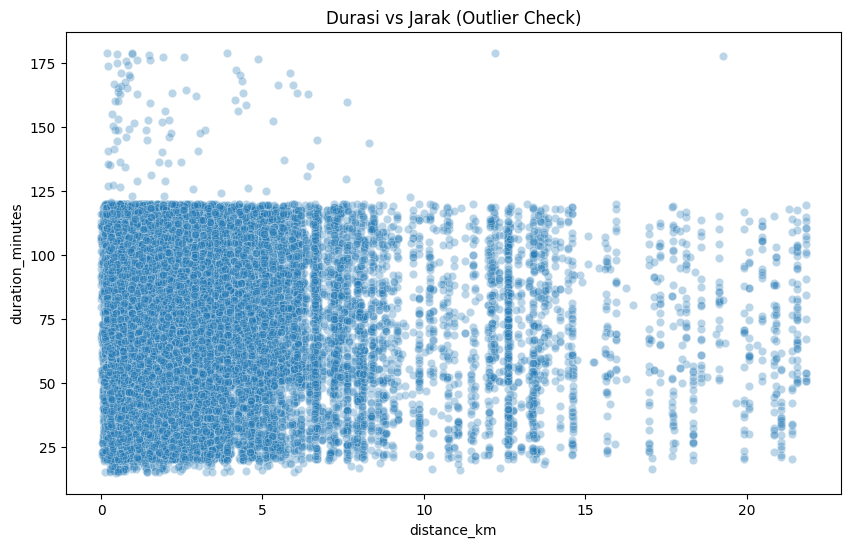

Jumlah outlier (jarak <2 km & durasi >60 menit): 12365


In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='distance_km', y='duration_minutes', data=df, alpha=0.3)
plt.title("Durasi vs Jarak (Outlier Check)")
plt.show()

outliers = df[(df['distance_km'] < 2) & (df['duration_minutes'] > 60)]
print("Jumlah outlier (jarak <2 km & durasi >60 menit):", outliers.shape[0])

## Rata-rata durasi per kategori waktu

/tmp/ipython-input-2316203764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_timecat.index, y=avg_timecat.values, palette="Set1")


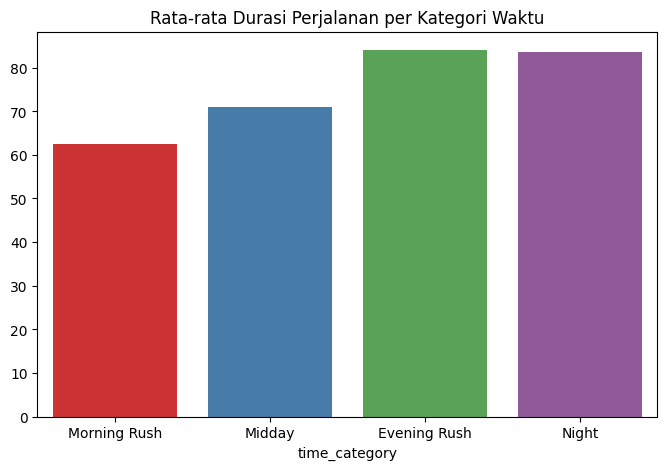

In [37]:
avg_timecat = df.groupby('time_category')['duration_minutes'].mean().reindex(["Morning Rush","Midday","Evening Rush","Night"])
plt.figure(figsize=(8,5))
sns.barplot(x=avg_timecat.index, y=avg_timecat.values, palette="Set1")
plt.title("Rata-rata Durasi Perjalanan per Kategori Waktu")
plt.show()

## Top 10 halte

/tmp/ipython-input-1672564919.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tapin.values, y=top_tapin.index, palette="Blues_r")


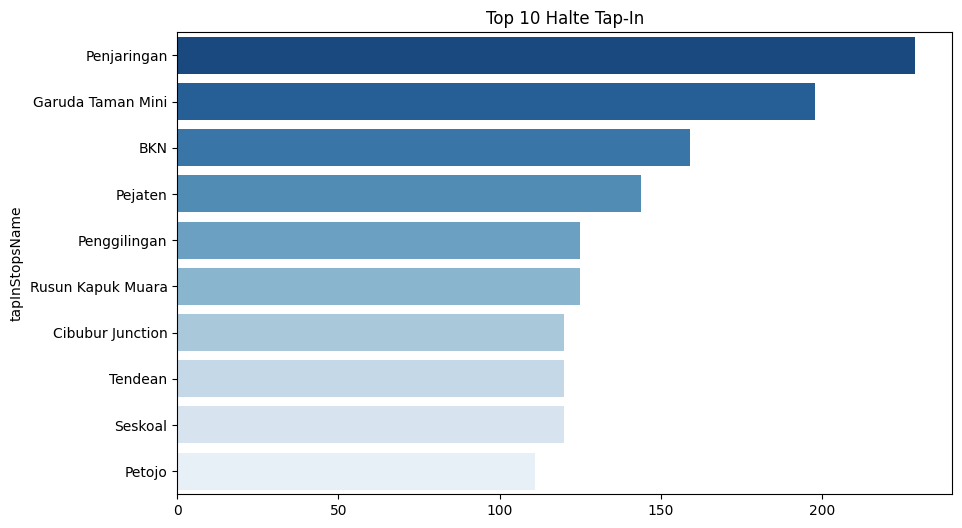

In [38]:
top_tapin = df['tapInStopsName'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_tapin.values, y=top_tapin.index, palette="Blues_r")
plt.title("Top 10 Halte Tap-In")
plt.show()

/tmp/ipython-input-2584576568.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tapout.values, y=top_tapout.index, palette="Greens_r")


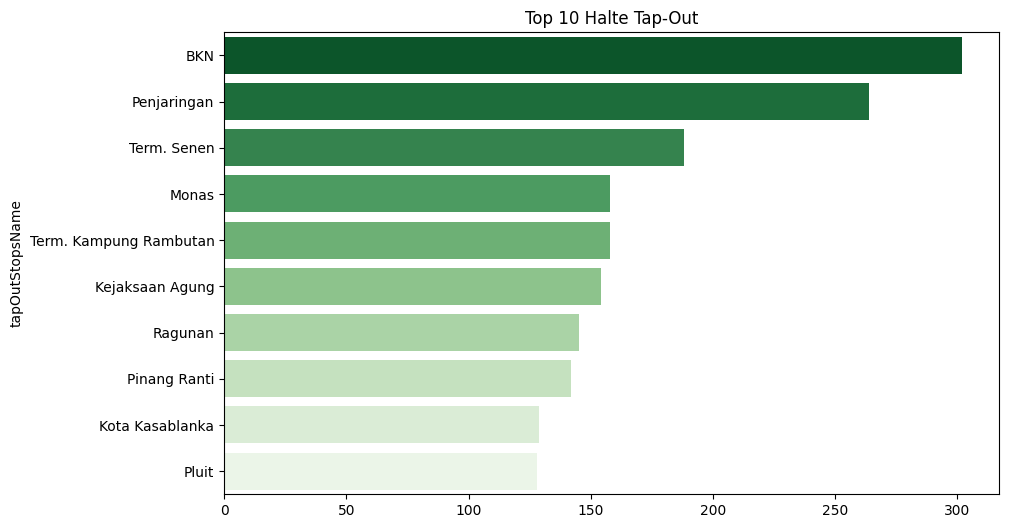

In [39]:
top_tapout = df['tapOutStopsName'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_tapout.values, y=top_tapout.index, palette="Greens_r")
plt.title("Top 10 Halte Tap-Out")
plt.show()